In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Shadow mask detection

In an attempt to better classify the pixels in the shadows, we carried out a shadow detection.

### Load data

In [6]:
hsi_raw = np.load("data/hyperspectral.npy")

In [7]:
rgb_bands = [54, 32, 18]
hsi_rgb = hsi_raw[:, :, rgb_bands]
hsi_rgb = (
    hsi_rgb / hsi_rgb.max()
)

pmin, pmax = np.percentile(hsi_rgb, (1, 95), axis=(0, 1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:, :, i] = (hsi_rgb[:, :, i] - pmin[i]) / (pmax[i] - pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped < 0] = 0
hsi_rgb_pimped[hsi_rgb_pimped > 1] = 1

#### View function

In [8]:
def display_shadow(mask):
    plt.figure(figsize=(20, 8))
    plt.subplot(211)
    plt.title("Version RGB de l'image hyperspectrale")
    plt.imshow(hsi_rgb_pimped)
    plt.subplot(212)
    plt.title("Shadow mask")
    plt.imshow(mask, cmap="gray")
    plt.show()

### Shadow mask detection

In an HSI space for RGB image, the intensity component is calculated as follows: 
$$I = avg(R, G,B) = \frac{R + G + B}{3}$$

So we calculated only the intensity component, and found a threshold for which the shadow was detected.

In [9]:
def detect_shadows_mask(image, threshold):
    m_intensity = np.mean(image, axis=2)
    threshold = np.percentile(m_intensity, threshold)
    mask = m_intensity < threshold
    return mask

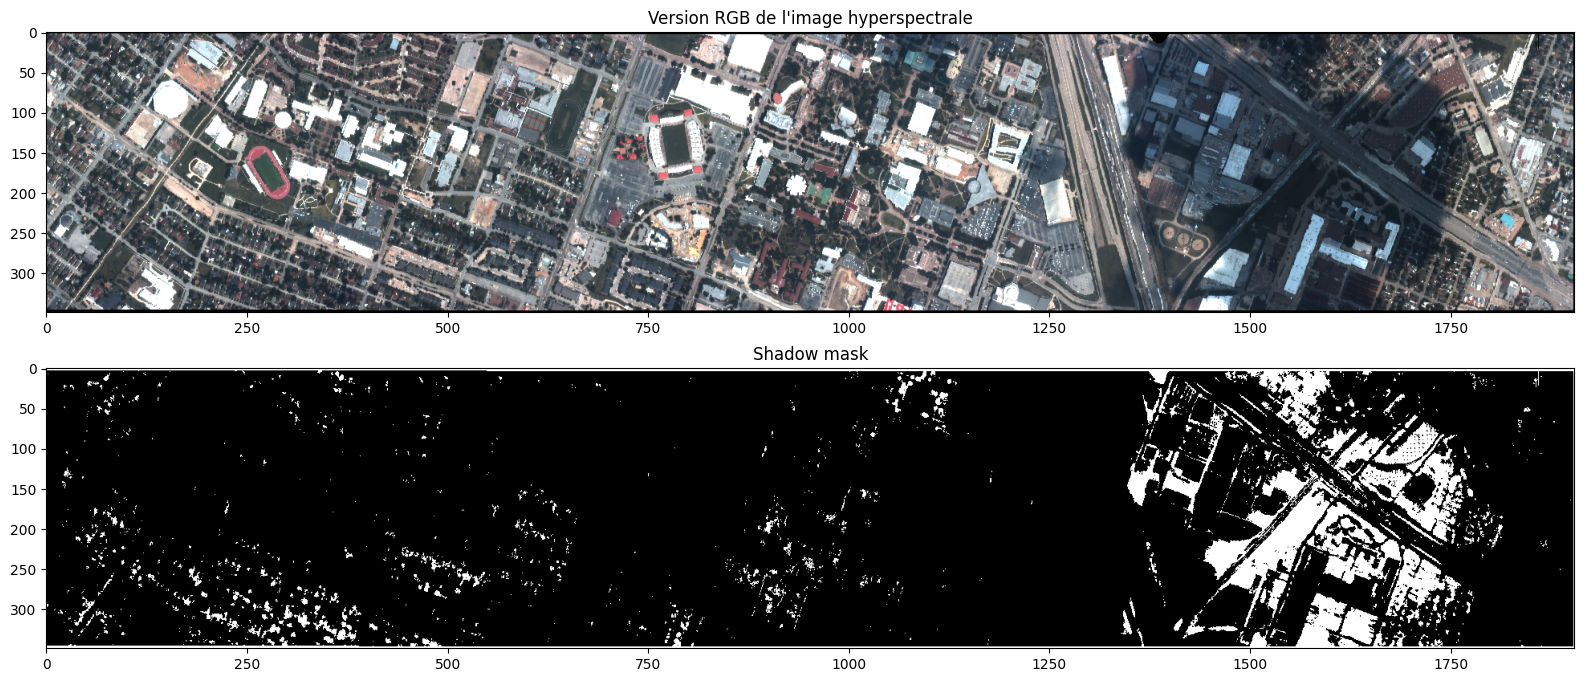

In [10]:
shadow_mask_from_rgb = detect_shadows_mask(hsi_rgb_pimped, 10)
display_shadow(shadow_mask_from_rgb)

The slightly darker areas were detected as shadows, but by lowering the shadow detection threshold, it's quite difficult to post-process them to get a consistent result. We noticed that by averaging all the features and applying a threshold the shadow was better detected.

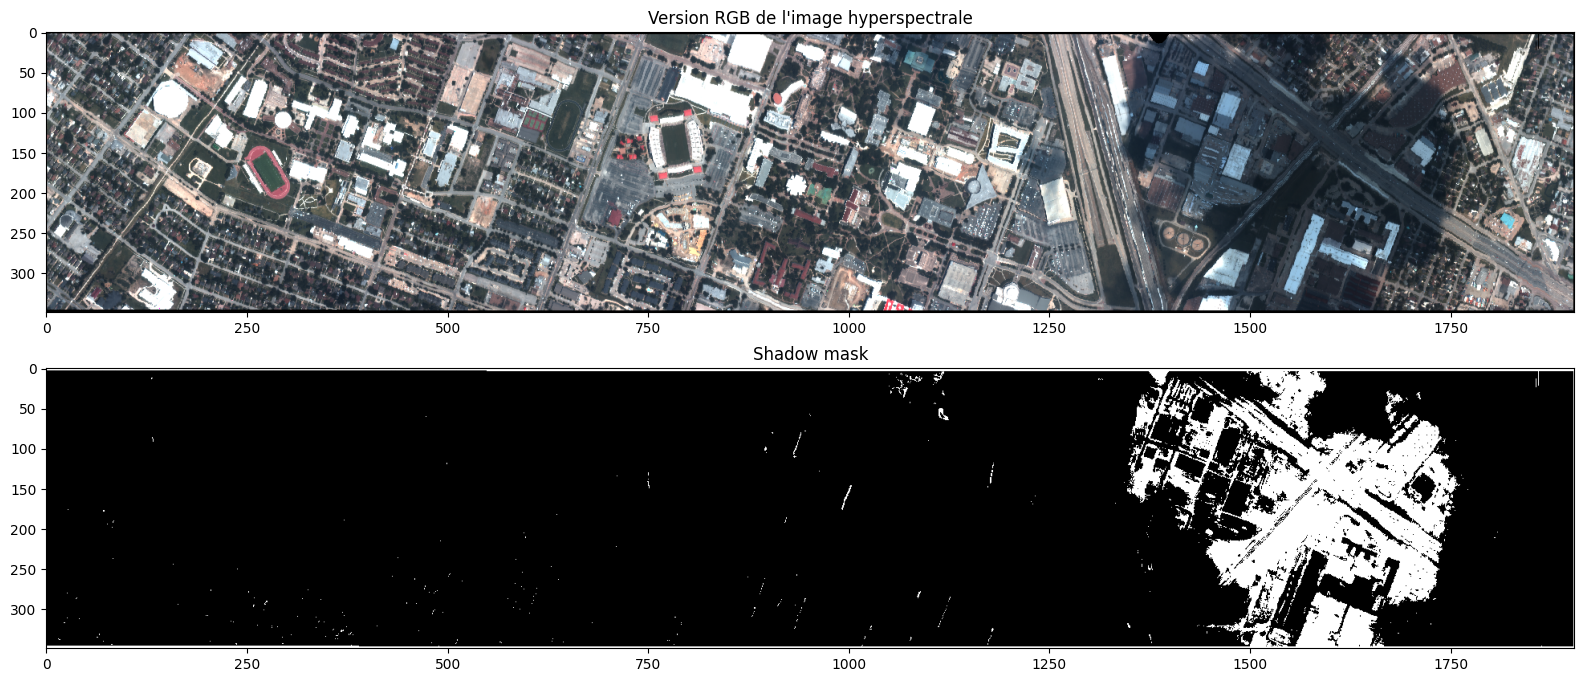

In [11]:
shadow_mask = detect_shadows_mask(hsi_raw, 11)
display_shadow(shadow_mask)

##### Post-processing

In [12]:
import skimage.morphology as sm

In [13]:
def detect_shadow_and_post_process(image):
    mask = detect_shadows_mask(image, 11)
    shadow_pp = sm.opening(mask, sm.square(3))
    shadow_pp = sm.closing(shadow_pp, sm.disk(25))
    return shadow_pp

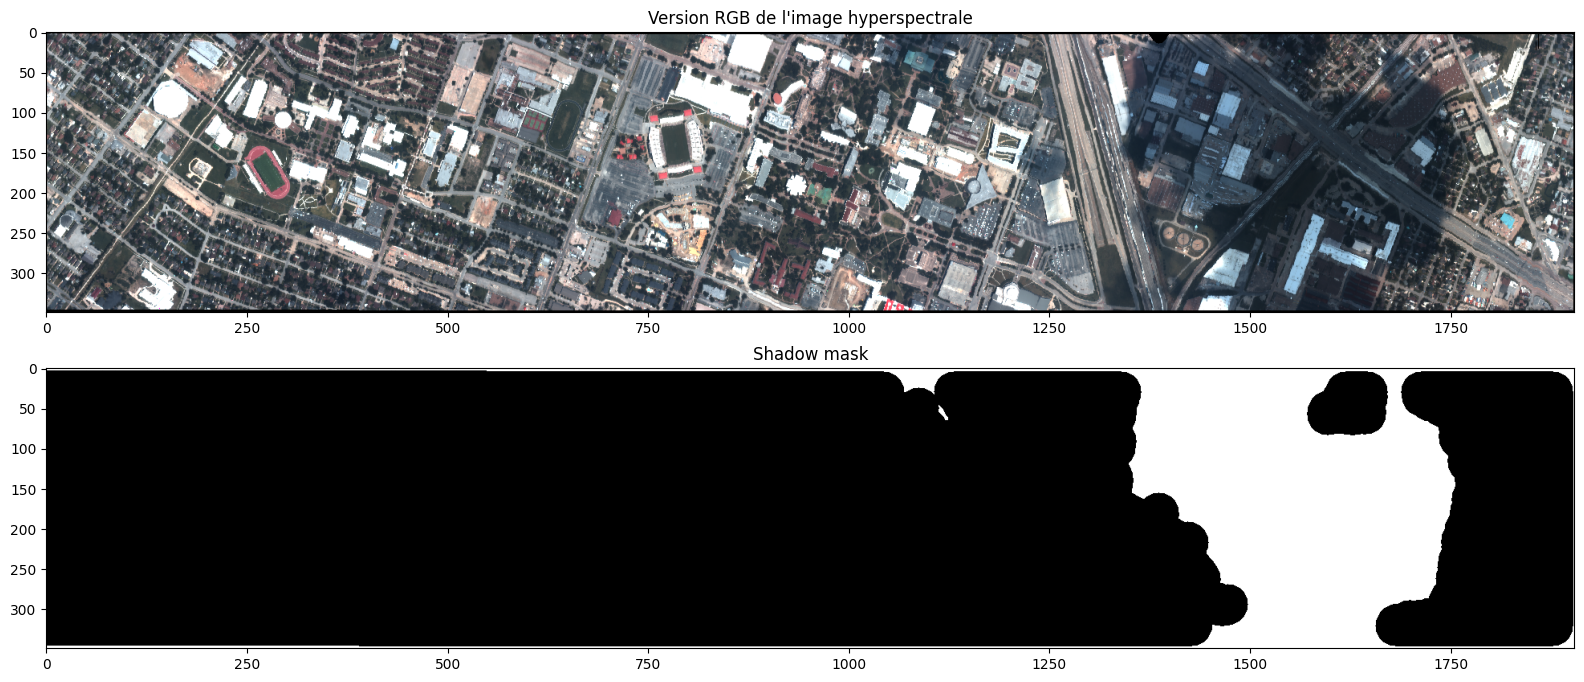

In [14]:
shadow_mask = detect_shadow_and_post_process(hsi_raw)
display_shadow(shadow_mask)

### Add shadow_mask feature and preparation of data for classification

In [15]:
hsi_raw_shadow = np.concatenate((hsi_raw, shadow_mask[:, :, np.newaxis]), axis=2)
hsi_raw_shadow.shape

(349, 1905, 145)

In [16]:
groundtruth = np.load("groundtruth/groundtruth.npy").reshape(-1)
hsi = hsi_raw_shadow.reshape(-1, hsi_raw_shadow.shape[-1])
idx = groundtruth.nonzero()[0]

X = hsi[idx]
y = groundtruth[idx]

X.shape, y.shape

((2832, 145), (2832,))

### Classification with HistGradientBoostingClassifier

In [17]:
from classifier import Classifier
from sklearn.ensemble import HistGradientBoostingClassifier
from utils import Classes

In [18]:
classes = [
    Classes.GRASS_HEALTHY,
    Classes.GRASS_STRESSED,
    Classes.GRASS_SYNTHETIC,
    Classes.TREE,
    Classes.SOIL,
    Classes.WATER,
    Classes.RESIDENTIAL,
    Classes.COMMERCIAL,
    Classes.ROAD,
    Classes.HIGHWAY,
    Classes.RAILWAY,
    Classes.PARKING_LOT1,
    Classes.PARKING_LOT2,
    Classes.TENNIS_COURT,
    Classes.RUNNING_TRACK,
]

In [19]:
HGBSClassifier_model = Classifier(
    classes,
    HistGradientBoostingClassifier(random_state=0, max_iter=150),
)

X_train, Y_train, X_test, Y_test = HGBSClassifier_model._dataset_get(X, y, test_size=0.2)

In [20]:
HGBSClassifier_model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(max_iter=150, random_state=0))])

In [21]:
HGBSClassifier_model.score(X_test, Y_test)

0.9029982363315696

### Display of qualitative results


In [25]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [32]:
def predict_and_display(model, image):
    def display(img, cmap):
        plt.figure(figsize=(15, 15))
        plt.imshow(img, cmap=cmap)
    def display_confusion_matrix(Y_test, y_pred):
        cm = confusion_matrix(Y_test, y_pred)
        print(cm)
    cmap = ListedColormap(
        np.array(
            [
                [[0.0, 0.80392157, 0.0]],
                [[0.49803922, 1.0, 0.0]],
                [[0.18039216, 0.80392157, 0.34117647]],
                [[0.0, 0.54509804, 0.0]],
                [[0.62745098, 0.32156863, 0.17647059]],
                [[0.0, 1.0, 1.0]],
                [[1.0, 1.0, 1.0]],
                [[0.84705882, 0.74901961, 0.84705882]],
                [[1.0, 0.0, 0.0]],
                [[0.54509804, 0.0, 0.0]],
                [[0.39215686, 0.39215686, 0.39215686]],
                [[1.0, 1.0, 0.0]],
                [[0.93333333, 0.60392157, 0.0]],
                [[0.33333333, 0.10196078, 0.54509804]],
                [[1.0, 0.49803922, 0.31372549]],
            ]
        )
    )
    hsi_reshaped = image.reshape(-1, image.shape[-1])
    y_pred = model.predict(hsi_reshaped)
    img_pred = y_pred.reshape((349, 1905))
    # display_confusion_matrix(Y_test, y_pred)
    display(img_pred, cmap)

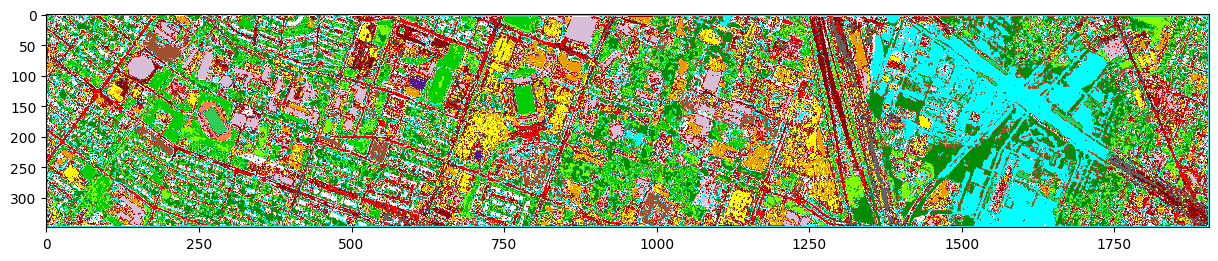

In [33]:
predict_and_display(HGBSClassifier_model, hsi_raw_shadow)